In [69]:
import numpy as np

def ProcessData(data,n_steps):
    def getXYdata(data):
        from sklearn.preprocessing import LabelEncoder
        yData = []
        X = data.get_data()
        contador = 0
        start_t = data.annotations.onset
        for i in range(0,X.shape[1]):
            time = i/160
            if contador < data.annotations.description.shape[0]:
                if time >= start_t[contador]:
                    contador = contador + 1
            yData.append(data.annotations.description[contador-1])
        yData = np.array(yData)
        le = LabelEncoder()
        le.fit(yData)
        yData = le.transform(yData)
        return X.T,yData

    Xdata,yData = getXYdata(data)
    features = 64  


    def splitTimeSeries(Xdata,ydata,n_steps):
        X = np.zeros((Xdata.shape[0] - n_steps, n_steps, features)) #maybe put in a +1 here
        y = np.zeros((Xdata.shape[0] - n_steps, 1))
        for i in range(n_steps, len(X)-1):
            X[i-n_steps] = Xdata[i-n_steps:i]
            y[i-n_steps] = ydata[i]
        return X,y
    
    return splitTimeSeries(Xdata,yData,n_steps)


In [70]:
import mne
import matplotlib.pyplot as plt
import numpy as np

#gathering all tests from a single individual
basePath = "physionet.org/files/eegmmidb/1.0.0/"
individual = 2
for exam in range(3,14):
    file = basePath+f"S{str(individual).zfill(3)}/S{str(individual).zfill(3)}R{str(exam).zfill(2)}.edf"
    data = mne.io.read_raw_edf(file)
    X,y = ProcessData(data,30)
    #concat the data
    if exam == 3:
        Xdata = X
        ydata = y
    else:
        Xdata = np.concatenate((Xdata,X),axis=0)
        ydata = np.concatenate((ydata,y),axis=0)


Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S002/S002R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S002/S002R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S002/S002R08.

In [77]:


index_80 = int(Xdata.shape[0]*0.8)

Xtrain,ytrain = Xdata[0:index_80],ydata[0:index_80]

Xval,yval = Xdata[index_80:],ydata[index_80:]
Xdata.shape

(216150, 30, 64)

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM



model = Sequential()
model.add(LSTM(units=64, activation="tanh", return_sequences=False, input_shape=(None, features)))
# model.add(LSTM(units=128, activation="tanh", return_sequences=False, input_shape=(None, features)))
model.add(Dense(units=3, activation="softmax"))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 33219 (129.76 KB)
Trainable params: 33219 (129.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
from keras.callbacks import ModelCheckpoint

# Define a checkpoint callback
checkpoint_path = "model_checkpoint.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

# Train the model with the checkpoint callback
result = model.fit(Xtrain, ytrain, epochs=500, batch_size=32, verbose=2, callbacks=[checkpoint],validation_data=(Xval, yval))

2023-11-19 01:34:13.790050: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1328025600 exceeds 10% of free system memory.
2023-11-19 01:34:15.646417: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1328025600 exceeds 10% of free system memory.


Epoch 1/500


2023-11-19 01:34:29.209146: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 332006400 exceeds 10% of free system memory.
2023-11-19 01:34:29.529197: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 332006400 exceeds 10% of free system memory.


5404/5404 - 15s - loss: 1.0400 - accuracy: 0.5007 - val_loss: 1.0387 - val_accuracy: 0.5014 - 15s/epoch - 3ms/step
Epoch 2/500


/home/andre/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5404/5404 - 13s - loss: 1.0395 - accuracy: 0.5007 - val_loss: 1.0388 - val_accuracy: 0.5014 - 13s/epoch - 2ms/step
Epoch 3/500
5404/5404 - 14s - loss: 1.0394 - accuracy: 0.5007 - val_loss: 1.0388 - val_accuracy: 0.5014 - 14s/epoch - 3ms/step
Epoch 4/500
5404/5404 - 13s - loss: 1.0393 - accuracy: 0.5007 - val_loss: 1.0387 - val_accuracy: 0.5014 - 13s/epoch - 2ms/step
Epoch 5/500
5404/5404 - 14s - loss: 1.0393 - accuracy: 0.5007 - val_loss: 1.0390 - val_accuracy: 0.5014 - 14s/epoch - 3ms/step
Epoch 6/500
5404/5404 - 14s - loss: 1.0393 - accuracy: 0.5007 - val_loss: 1.0385 - val_accuracy: 0.5014 - 14s/epoch - 3ms/step
Epoch 7/500


KeyboardInterrupt: 

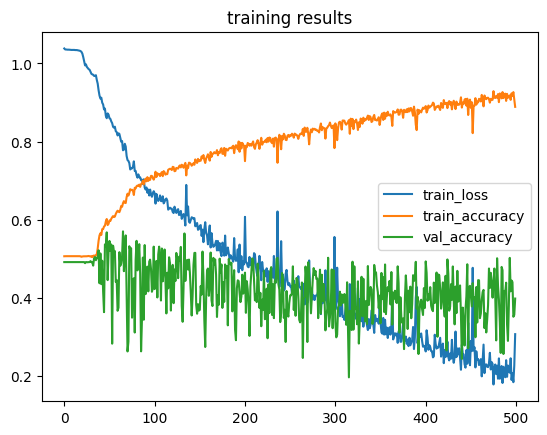

In [ ]:
plt.title("training results")
plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['accuracy'], label='train_accuracy')
plt.plot(result.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
ypred = model.predict(Xtrain)

500/500 [==============================] - 1s 1ms/step


In [ ]:
y2 = np.argmax(ypred, axis=1)

In [ ]:
y2.shape

(15970,)

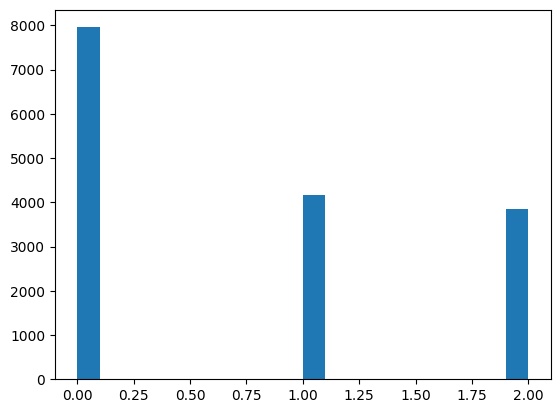

In [ ]:
plt.hist(y2, bins=20)
plt.show()